In [50]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_poisson_deviance, mean_gamma_deviance, mean_absolute_error

exploratory data analysis / cleaning

In [92]:
df_freq = pd.read_csv("freMTPL2freq.csv")
df_sev = pd.read_csv("freMTPL2sev.csv")

In [41]:

sev_ids = set(df_sev['IDpol'])

# filtering only claims the result in an insurer payment
mask = (df_freq['ClaimNb'] >= 1) & (~df_freq['IDpol'].isin(sev_ids))
df_freq.loc[mask, 'ClaimNb'] = 0

count_sev_ids = len(sev_ids)
print(f"Number of unique IDs in df_sev: {count_sev_ids}")

ids_freq_with_claims = df_freq[df_freq['ClaimNb'] >= 1]['IDpol'].nunique()
print(f"Number of unique IDs in df_freq with ClaimNb >= 1 (after update): {ids_freq_with_claims}")


Number of unique IDs in df_sev: 24950
Number of unique IDs in df_freq with ClaimNb >= 1 (after update): 24944


C:\Users\kylek\AppData\Local\Temp\ipykernel_1864\1309174572.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(feature)[['ClaimNb', 'Exposure']].sum()


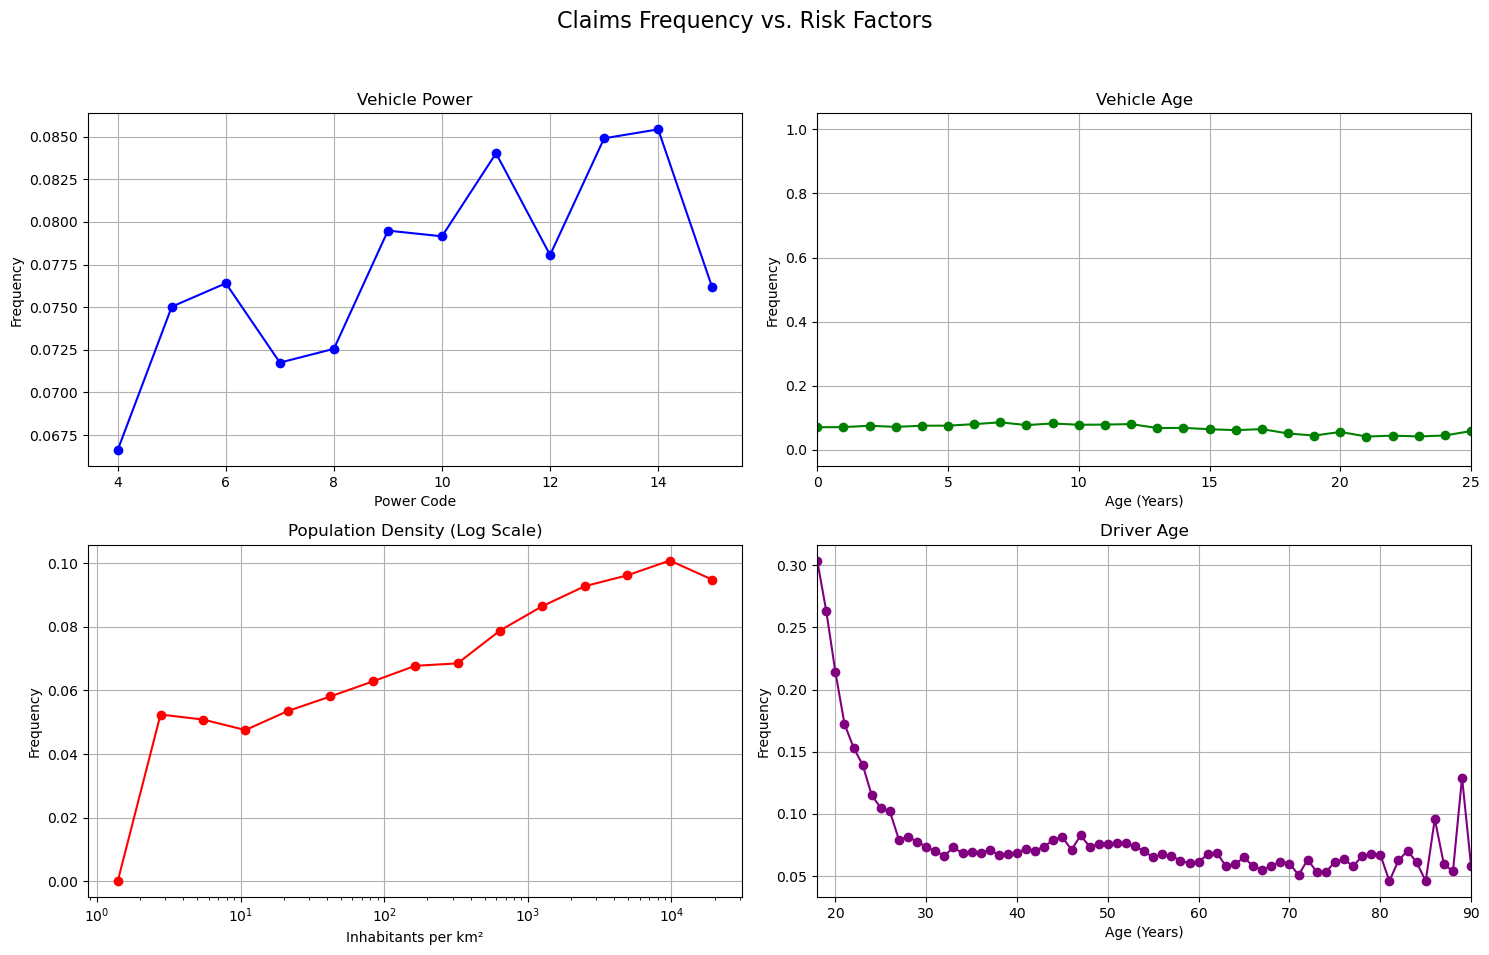

In [42]:
def calculate_frequency(data, feature):
    grouped = data.groupby(feature)[['ClaimNb', 'Exposure']].sum()
    grouped['Frequency'] = grouped['ClaimNb'] / grouped['Exposure']
    return grouped

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Claims Frequency vs. Risk Factors', fontsize=16)

# Vehpower
freq_power = calculate_frequency(df_freq, 'VehPower')
axes[0, 0].plot(freq_power.index, freq_power['Frequency'], marker='o', color='b')
axes[0, 0].set_title('Vehicle Power')
axes[0, 0].set_xlabel('Power Code')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Vehage
freq_veh_age = calculate_frequency(df_freq, 'VehAge')
# Limiting x-axis to 25 years to avoid noise from rare vintage cars
axes[0, 1].plot(freq_veh_age.index, freq_veh_age['Frequency'], marker='o', color='g')
axes[0, 1].set_title('Vehicle Age')
axes[0, 1].set_xlabel('Age (Years)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(0, 25)
axes[0, 1].grid(True)

# logscale density
df_freq['LogDensity'] = np.log10(df_freq['Density'])
df_freq['DensityBin'] = pd.cut(df_freq['LogDensity'], bins=15)

# Calculate frequency for these bins
freq_density = calculate_frequency(df_freq, 'DensityBin')


x_axis_density = [10**interval.mid for interval in freq_density.index]

axes[1, 0].plot(x_axis_density, freq_density['Frequency'], marker='o', color='r')
axes[1, 0].set_title('Population Density (Log Scale)')
axes[1, 0].set_xlabel('Inhabitants per km²')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True)

# DribAge
freq_driv_age = calculate_frequency(df_freq, 'DrivAge')
# filter noise for extremely old ages (e.g. > 90)
freq_driv_age = freq_driv_age[freq_driv_age['Exposure'] > 100]

axes[1, 1].plot(freq_driv_age.index, freq_driv_age['Frequency'], marker='o', color='purple')
axes[1, 1].set_title('Driver Age')
axes[1, 1].set_xlabel('Age (Years)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(18, 90)
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [44]:
print(np.mean(df_freq['ClaimNb']))
print(np.var(df_freq['ClaimNb']))

0.039003676920649016
0.04292181383484864


claims model training

In [93]:

# feature selection based on exploratory data analysis
features = ['VehPower', 'VehAge', 'Density', 'DrivAge']
target = 'ClaimNb'

X = df_freq[features]
y = df_freq[target]

# create the offset (Log Exposure) for poisson regression. since poission regression predicts log of expected count
# modeleling log(Claims) = log(Exposure) + Model_Output
df_freq['log_exposure'] = np.log(df_freq['Exposure'])

log_exposure = df_freq['log_exposure'] # the offset
exposure = df_freq['Exposure']         # the original exposure (for scaling later)

# train,test split
X_train, X_test, y_train, y_test, log_exp_train, log_exp_test, exp_train, exp_test = train_test_split(
    X, y, log_exposure, exposure, test_size=0.2, random_state=42
)


# xgb model
xgb_model = xgb.XGBRegressor(
    objective='count:poisson', # Tells XGBoost to minimize Poisson loss
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,               # Slightly deeper to capture interactions
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train, y_train, base_margin=log_exp_train)


# passing base_margin=log_exp_test here, XGBoost automatically calculates:
# Predicted_Claims = exp(Model_Output + log_exposure) i.e. no longer logged
pred_claims = xgb_model.predict(X_test, base_margin=log_exp_test)

#calculate predicted frequency 
pred_frequency = pred_claims / exp_test


# results 
print("\n--- Results ---")
total_actual = y_test.sum()
total_predicted = pred_claims.sum()

print(f"Total Actual Claims:    {total_actual}")
print(f"Total Predicted Claims: {total_predicted:.2f}")
print(f"Difference:             {((total_predicted - total_actual) / total_actual) * 100:.2f}%")

# # Poisson Deviance
# deviance = mean_poisson_deviance(y_test, pred_claims)
# print(f"Poisson Deviance:       {deviance:.4f}")

# # RMSE on frequency
# actual_frequency = y_test / exp_test
# rmse = np.sqrt(mean_squared_error(actual_frequency, pred_frequency))
# print(f"RMSE (Frequency):       {rmse:.4f}")




--- Results ---
Total Actual Claims:    7241
Total Predicted Claims: 7610.43
Difference:             5.10%


testing claims model

In [95]:
new_driver_data = pd.DataFrame({
    'VehPower': [7],      # power level 7
    'VehAge': [5],       # 5-year-old car
    'Density': [1500],   # 1500 people/km^2
    'DrivAge': [22]        # 25-yr-old driver
})

print("Input data for the new driver:")
print(new_driver_data)

# annual frequency offset (Exposure = 1.0)
# need log(Exposure), and np.log(1.0) is 0.0
annual_offset = [0.0]


predicted_frequency = xgb_model.predict(
    new_driver_data,
    base_margin=annual_offset
)[0] 

print(f"\nPredicted Annual Claims Frequency: {predicted_frequency:.5f}")


Input data for the new driver:
   VehPower  VehAge  Density  DrivAge
0         7       5     1500       22

Predicted Annual Claims Frequency: 0.24882


severity model training

In [99]:
sev_grouped = df_sev.groupby('IDpol')['ClaimAmount'].sum().reset_index()
df_merged = pd.merge(df_freq, sev_grouped, on='IDpol', how='left')
df_merged['ClaimAmount'] = df_merged['ClaimAmount'].fillna(0)
df_severity_train = df_merged[df_merged['ClaimAmount'] > 0].copy()

# target: average cost per claim 
df_severity_train['AvgClaimAmount'] = df_severity_train['ClaimAmount'] / df_severity_train['ClaimNb']

In [100]:
features = ['VehPower', 'VehAge', 'Density', 'DrivAge']
target = 'AvgClaimAmount'


X = df_severity_train[features]
y = df_severity_train[target]
weights = df_severity_train['ClaimNb']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)



xgb_sev = xgb.XGBRegressor(
    objective='reg:gamma',    #gamma objective not poisson
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    base_score = y_train.mean(),              
    n_jobs=-1,
    random_state=42
)

xgb_sev.fit(X_train, y_train, sample_weight=w_train)


pred_severity = xgb_sev.predict(X_test)

# Mean Gamma Deviance (The standard actuarial metric for severity)
# 2 * (log(y_pred/y_true) + (y_true/y_pred) - 1)
try:
    gamma_dev = mean_gamma_deviance(y_test, pred_severity)
    print(f"Mean Gamma Deviance: {gamma_dev:.4f}")
except:
    print("Could not calculate Gamma Deviance (likely due to 0 or negative predictions)")

# Mean Absolute Error (Interpretability)
mae = mean_absolute_error(y_test, pred_severity)
print(f"Mean Absolute Error:   {mae:.2f}")

print(f"\nAvg Actual Severity:   {y_test.mean():.2f}")
print(f"Avg Predicted Severity:{pred_severity.mean():.2f}")

Mean Gamma Deviance: 1.4775
Mean Absolute Error:   1763.68

Avg Actual Severity:   1977.94
Avg Predicted Severity:1966.93


using a log model

In [101]:
y_train_log = np.log(y_train)
xgb_log = xgb.XGBRegressor(
    objective='reg:squarederror', # Standard regression
    n_estimators=300,
    learning_rate=0.05
)
xgb_log.fit(X_train, y_train_log, sample_weight=w_train)

train_log_preds = xgb_log.predict(X_train)

train_residuals = y_train_log - train_log_preds

# correction factor (Duan's Smearing Estimator)
correction_factor = np.mean(np.exp(train_residuals))

print(f"The Correction Factor is: {correction_factor:.4f}")

pred_log = xgb_log.predict(X_test)
pred_severity_corrected = np.exp(pred_log) * correction_factor

print(f"Avg Predicted Severity (Uncorrected): {np.exp(pred_log).mean():.2f}")
print(f"Avg Predicted Severity (Corrected):   {pred_severity_corrected.mean():.2f}")

The Correction Factor is: 1.8270
Avg Predicted Severity (Uncorrected): 978.90
Avg Predicted Severity (Corrected):   1788.44


pure premium

In [102]:
freq_pred = xgb_model.predict(new_driver_data, base_margin=annual_offset)[0]
sev_pred = xgb_sev.predict(new_driver_data)[0]
log_sev_pred = xgb_log.predict(new_driver_data)[0]

pure_premium = freq_pred * sev_pred
pure_prem_log = freq_pred * log_sev_pred

print(f"Predicted Claim Count: {freq_pred:.4f}")
print(f"Predicted Cost per Claim: {sev_pred:.2f}")
print(f"Total Expected Loss (Premium): {pure_premium:.2f}")

Predicted Claim Count: 0.2488
Predicted Cost per Claim: 2335.85
Total Expected Loss (Premium): 581.21
